In [8]:
# Importar las librerias necesarias para hacer un EDA   
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# Leer los datos
df_imss = pd.read_csv('data/tidy_imss.csv')
df_agp = pd.read_csv('data/tidy_agricultura_ganaderia_pesca.csv')

> Dado que estamos trabajando con dos tablas tidy, haremos un análisis primero para uno y después repetiremos el análisis para el segundo.

#### Análisis con el datraframe IMSS

In [10]:
# Ver la información de los datos del IMSS
df_imss.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629639 entries, 0 to 629638
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   rango_salarial              628979 non-null  object
 1   asegurados                  629639 non-null  int64 
 2   no_trabajadores             629639 non-null  int64 
 3   año                         629639 non-null  int64 
 4   mes                         629639 non-null  int64 
 5   fecha                       629639 non-null  object
 6   municipio                   629639 non-null  object
 7   sector_economico_1          629639 non-null  object
 8   sector_economico_2          629639 non-null  object
 9   sector_economico_4          629639 non-null  object
 10  tamaño_patronal             629639 non-null  object
 11  sexo                        629639 non-null  object
 12  rango_edad                  629639 non-null  object
 13  rango_salarial_descripcion  6

In [11]:
# Contamos la cantidad de datos nulos por columna
df_imss.isnull().sum()

rango_salarial                660
asegurados                      0
no_trabajadores                 0
año                             0
mes                             0
fecha                           0
municipio                       0
sector_economico_1              0
sector_economico_2              0
sector_economico_4              0
tamaño_patronal                 0
sexo                            0
rango_edad                      0
rango_salarial_descripcion      0
dtype: int64

In [12]:
# En vez de eliminar los datos nulos, los rellenamos con 'No especificado' dado que no 
# sabemos el motivo por el cual no se registraron
df_imss.rango_salarial.fillna('No especificado', inplace=True)

In [13]:
# Ahora empezamos a buscar los datos atípicos
# Para esto, vemos una descripción de los datos
df_imss.describe()

,asegurados,no_trabajadores,año,mes
count,629639.000000,629639.0,629639.000000,629639.000000
mean,5.770886,0.0,2020.024363,6.488351
std,17.426313,0.0,1.426229,3.453441
min,1.000000,0.0,2018.000000,1.000000
25%,1.000000,0.0,2019.000000,3.000000
50%,2.000000,0.0,2020.000000,6.000000
75%,4.000000,0.0,2021.000000,10.000000
max,1378.000000,0.0,2022.000000,12.000000


Observando las primeras dos columnas vemos que, en la columna de `asegurados` hay un valor que claramente es un outlier, pero por otra parte tenemos que la columna de `no_trabajadores` tiene un comportamiento atípico, dado que todos sus valores son ceros.


> Para este caso ignoraremos las columnas de año y mes. 

In [14]:
# Eliminamos la columna de no_trabajadores dado que no nos sirve para el análisis
df_imss.drop('no_trabajadores', axis=1, inplace=True)

<AxesSubplot: xlabel='asegurados', ylabel='sector_economico_4'>

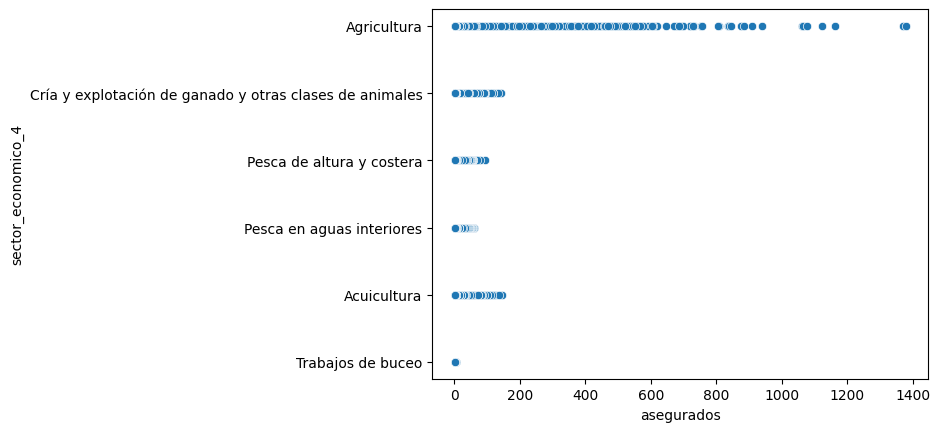

In [15]:
# Hacemos un scatterplot para ver la relación entre los asegurados y el sector económico
# Sabemos que el numero de asegurados depende del sector económico, pero queremos ver si
# hay algún sector que tenga una gran cantidad de asegurados o muy pocos
sns.scatterplot(x=df_imss.asegurados, y=df_imss.sector_economico_4)

Al ver esta gráfica pudieramos decir que no hay outliers, aunque pareciera lo contrario. Sabemos que hay zonas de agricultura que tienen una gran cantidad de trabajadores, pensar que hay zonas, o empresas, con casi 1400 trabajadores asegurados no debería extrañarnos. 

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EmpiricalCovariance, MinCovDet

# Creamos un dataframe con las columnas que nos interesan y las codificamos
df_outliers = df_imss[['asegurados', 'sector_economico_4']].copy()

# Creamos un encoder
le = LabelEncoder()

# Codificamos la columna de sector económico
df_outliers['sector_economico_4'] = le.fit_transform(df_outliers['sector_economico_4'])

# Convertimos el dataframe a un arreglo de numpy
X = df_outliers[['asegurados', 'sector_economico_4']].to_numpy()
X.shape

(629639, 2)

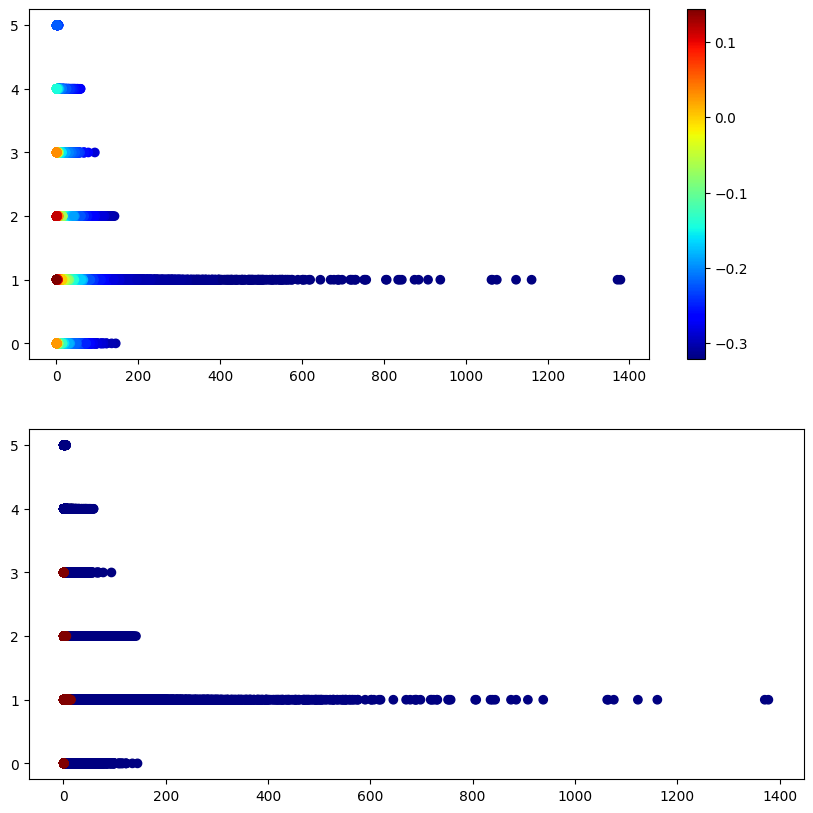

In [17]:
# Creamos el modelo de IsolationForest con el parámetro correcto 'n_estimators'
clf = IsolationForest(n_estimators=100)

# Entrenamos el modelo
clf.fit(X)

# Obtenemos el estimado de la función de decisión
estimado_IF = clf.decision_function(X)

plt.figure(figsize=(10, 10))

# Graficamos los datos
plt.subplot(2, 1, 1)
plt.scatter(x=X[:,0], y=X[:,1], c=estimado_IF, cmap='jet')
plt.colorbar() 

# Graficamos los datos nuevamente pero ahora con los datos atípicos resaltados
plt.subplot(2, 1, 2)
plt.scatter(x=X[:,0], y=X[:,1], c=np.where(estimado_IF > 0, 1, 0), cmap='jet')
plt.show()

Aquí podemos observar cómo el valor que es mayor entre los demás, para el grupo de Agricultura, no resultó ser un valor atípico, sin embargo, para este y otros grupos, los valores más pequeños resultan serlo.

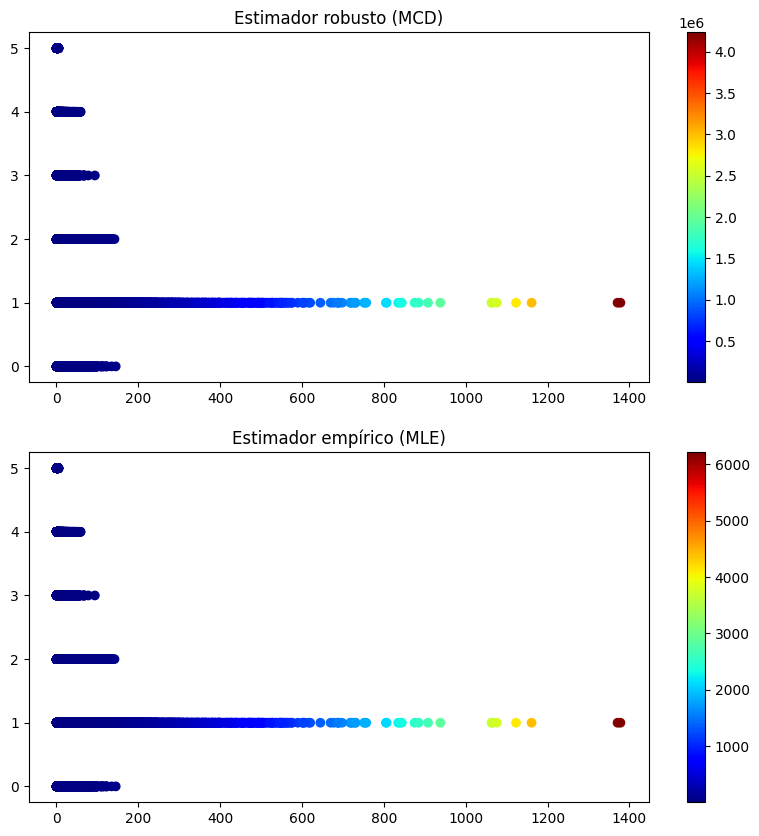

In [18]:
# Estimador robusto (MCD)
robust_cov = MinCovDet().fit(X)
estimado_MCD = robust_cov.mahalanobis(X)

# Estimador empírico (MLE)
emp_cov = EmpiricalCovariance().fit(X)
estimado_MLE = emp_cov.mahalanobis(X)

plt.figure(figsize=(10, 10))

# Graficamos los datos, primero con el estimador MCD
plt.subplot(2, 1, 1)
plt.scatter(x=X[:,0], y=X[:,1], c=estimado_MCD, cmap='jet')
plt.colorbar()
plt.title('Estimador robusto (MCD)')

# Graficamos los datos, ahora con el estimador MLE
plt.subplot(2, 1, 2)
plt.scatter(x=X[:,0], y=X[:,1], c=estimado_MLE, cmap='jet')
plt.colorbar()
plt.title('Estimador empírico (MLE)')

plt.show()

Con este modelo vemos que para ambos estimadores se han identificado los mismos outliers, valores atípicos en el sector agrícola. Sin embargo, comparando este modelo con el anterior (Isolation Forest), vemos que solo se identificaron outliers en este sector, cuando en el anterior había outliers en 4 sectores. 

#### Análisis con el datraframe AGP

In [19]:
# Ver la información de los datos de la agricultura, ganadería y pesca
df_agp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8734 entries, 0 to 8733
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ANO              8734 non-null   object 
 1   SECTOR           8734 non-null   object 
 2   CVE_DDR          8734 non-null   int64  
 3   CVE_MUN          8734 non-null   int64  
 4   ESPECIE_CULTIVO  8734 non-null   object 
 5   TIPO             8734 non-null   object 
 6   PRODTON          8734 non-null   float64
 7   VALPROD          8734 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 546.0+ KB


In [20]:
# Contamos la cantidad de datos nulos por columna
df_agp.isnull().sum()

ANO                0
SECTOR             0
CVE_DDR            0
CVE_MUN            0
ESPECIE_CULTIVO    0
TIPO               0
PRODTON            0
VALPROD            0
dtype: int64

En este caso, vemos que no hay datos faltantes, por lo que pasamos al paso siguiente.

In [21]:
# Ahora empezamos a buscar los datos atípicos
# Para esto, vemos una descripción de los datos
df_agp.describe()

,CVE_DDR,CVE_MUN,PRODTON,VALPROD
count,8734.000000,8734.000000,8.734000e+03,8.734000e+03
mean,146.071216,35.027364,3.961207e+05,4.293055e+04
std,10.000765,18.953632,6.939311e+06,2.434949e+05
min,139.000000,1.000000,0.000000e+00,0.000000e+00
25%,142.000000,20.000000,1.772500e+00,2.721250e+01
50%,144.000000,30.000000,3.260300e+02,9.229300e+02
75%,148.000000,49.000000,2.944762e+03,8.936125e+03
max,193.000000,72.000000,2.688360e+08,5.018198e+06


Queriendo hacer una observación rápida, o descriptiva, de los datos, vemos que es complicado dado la naturaleza de los datos y el cómo varían por sectores. Por ello, agruparemos por sector y veremos una descripción de los datos nuevamente.

In [22]:
# Agrupamos por sector y seleccionamos las columnas que nos interesan
df_agp.groupby('SECTOR')[['PRODTON','VALPROD']].describe()

PRODTON                                                         \
              count          mean           std  min        25%        50%   
SECTOR                                                                       
Agricultura  5880.0  4.792170e+03  2.075406e+04  0.0    0.00000    252.000   
Ganadería    1610.0  2.148460e+03  9.287959e+03  0.0    3.53775    110.072   
Pesca        1244.0  2.755692e+06  1.821588e+07  0.0  428.75000  15732.000   

                                        VALPROD                               \
                      75%           max   count          mean            std   
SECTOR                                                                         
Agricultura    2112.56250  5.854322e+05  5880.0  35057.671405  197859.375094   
Ganadería       779.53925  9.558728e+04  1610.0  72428.506959  325640.961270   
Pesca        158176.75000  2.688360e+08  1244.0  41966.548522  304480.345003   

                                                               
             min       25%      50%          75%          max  
SECTOR                                                         
Agricultura  0.0    0.0000   890.40   7944.96750  5018197.910  
Ganadería    0.0  183.4935  2540.54  33361.19750  3750770.000  
Pesca        0.0    6.9125   374.70   3834.78025  4483132.541

A pesar de que se puede visualizar mejor, sigue siendo difícil observar los datos atípicos, por lo que vamos a hacer uso de métodos gráficos que nos ayuden a encontrarlos.

> Las columnas de `CVE_DDR` y `CVE_MUN` fueron ignoradas dado que son claves que ayudan a identificar regiones geográficas.

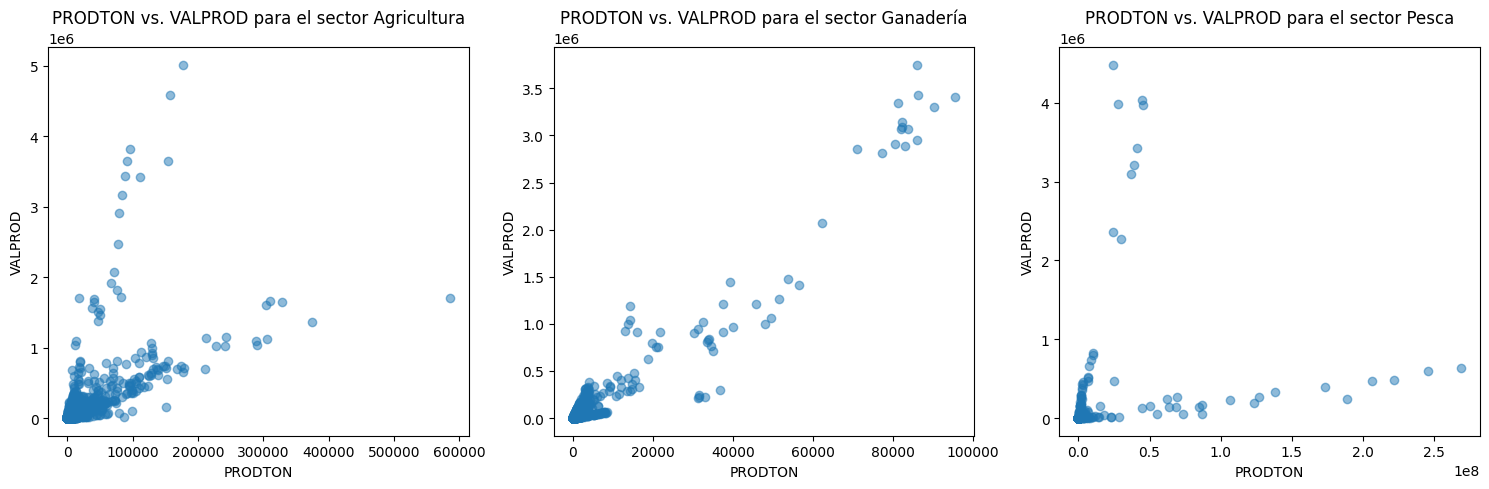

In [23]:
# Hacemos una lista de los sectores
sectores = df_agp['SECTOR'].unique()

# Definir las dimensiones de la figura y los subplots
fig, axs = plt.subplots(1, len(sectores), figsize=(15, 5))

for i, sector in enumerate(sectores):
    data_sector = df_agp[df_agp['SECTOR'] == sector]
    axs[i].scatter(data_sector['PRODTON'], data_sector['VALPROD'], alpha=0.5)
    axs[i].set_title(f'PRODTON vs. VALPROD para el sector {sector}')
    axs[i].set_xlabel('PRODTON')
    axs[i].set_ylabel('VALPROD')

# Ajustar el espacio entre los subplots para evitar superposiciones de etiquetas
plt.tight_layout()

# Mostrar la figura en pantalla
plt.show()

En estas gráficas es difícil poder visualizar los outliers que se encuentran en los datos. Para poder identificarlos, haremos uso de los métodos que se aplicaron anteriormente.

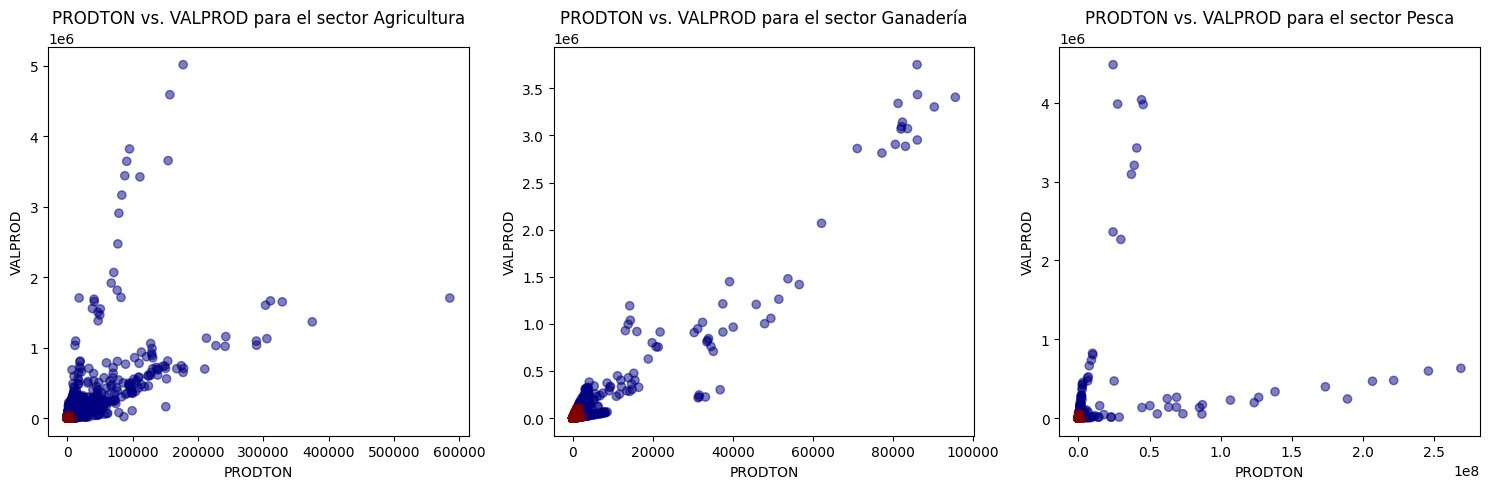

In [24]:
# Definir las dimensiones de la figura y los subplots
fig, axs = plt.subplots(1, len(sectores), figsize=(15, 5))

# Creamos un modelo de IsolationForest
clf = IsolationForest(n_estimators=100)

for i, sector in enumerate(sectores):
    # Obtenemos los datos del sector
    data_sector = df_agp[df_agp['SECTOR'] == sector][['PRODTON', 'VALPROD']].to_numpy()
    # Entrenamos el modelo
    clf.fit(data_sector)
    # Obtenemos el estimado de la función de decisión
    estimado_IF = clf.decision_function(data_sector)
    # Graficamos los datos en el subplot correspondiente
    axs[i].scatter(data_sector[:, 0], data_sector[:, 1], c=np.where(estimado_IF > 0, 1, 0), cmap='jet', alpha=0.5)
    axs[i].set_title(f'PRODTON vs. VALPROD para el sector {sector}')
    axs[i].set_xlabel('PRODTON')
    axs[i].set_ylabel('VALPROD')

# Ajustar el espacio entre los subplots para evitar superposiciones de etiquetas
plt.tight_layout()

# Mostrar
plt.show()

Aquí podemos observar los outliers que el modelo identificó. En este caso, para los 3 sectores, los outliers identificados fueron valores muy bajos, con certeza no podemos decir si son valores iguales a 0 por la magnitud de los valores, sin embargo, es un aspecto a tratar con los especialistas y poder decir con certeza si esos valores bajos son anomalías o no.

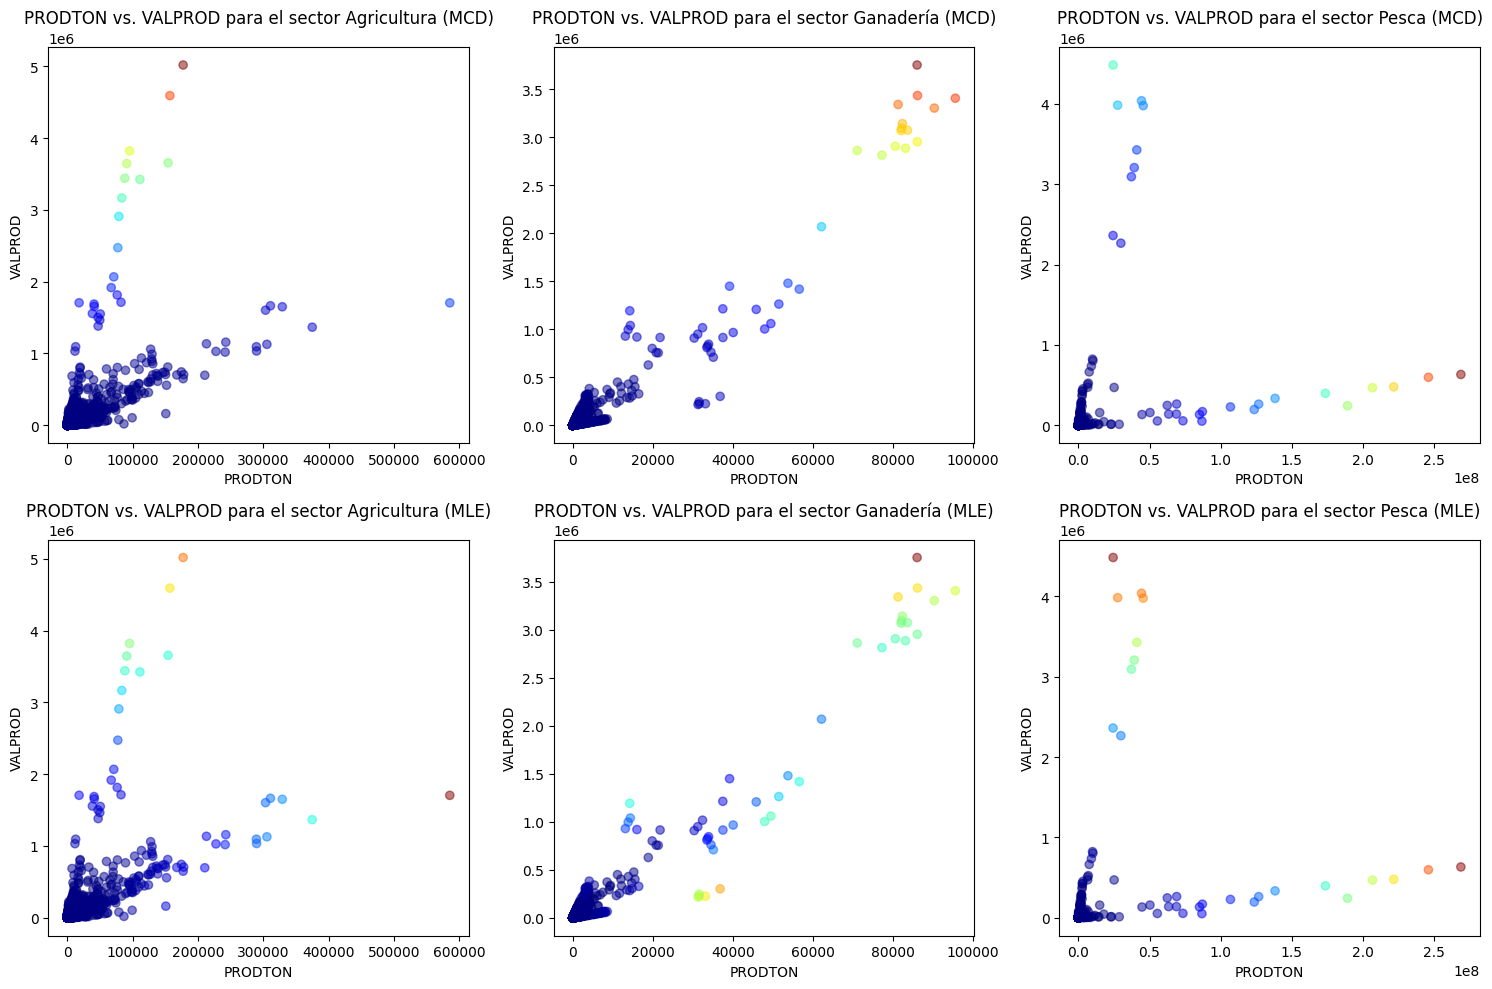

In [25]:
# Definir las dimensiones de la figura y los subplots
fig, axs = plt.subplots(2, len(sectores), figsize=(15, 10))

for i, sector in enumerate(sectores):
    # Obtenemos los datos del sector
    data_sector = df_agp[df_agp['SECTOR'] == sector][['PRODTON', 'VALPROD']].to_numpy()
    # Estimador robusto (MCD)
    robust_cov = MinCovDet().fit(data_sector)
    estimado_MCD = robust_cov.mahalanobis(data_sector)

    # Estimador empírico (MLE)
    emp_cov = EmpiricalCovariance().fit(data_sector)
    estimado_MLE = emp_cov.mahalanobis(data_sector)
    
    # Graficar los datos con el estimador MCD en el primer subplot
    axs[0, i].scatter(data_sector[:, 0], data_sector[:, 1], \
                      c=estimado_MCD, cmap='jet', alpha=0.5)
    axs[0, i].set_title(f'PRODTON vs. VALPROD para el sector {sector} (MCD)')
    axs[0, i].set_xlabel('PRODTON')
    axs[0, i].set_ylabel('VALPROD')

    # Graficar los datos con el estimador MLE en el segundo subplot
    axs[1, i].scatter(data_sector[:, 0], data_sector[:, 1], \
                      c=estimado_MLE, cmap='jet', alpha=0.5)
    axs[1, i].set_title(f'PRODTON vs. VALPROD para el sector {sector} (MLE)')
    axs[1, i].set_xlabel('PRODTON')
    axs[1, i].set_ylabel('VALPROD')

# Ajustar el espacio entre los subplots para evitar superposiciones de etiquetas
plt.tight_layout()

# Mostrar
plt.show()


En este otro caso, tenemos que los valores más grandes son identificados por el modelo como anomalías. Nuevamente no podemos decir con certeza si lo son o no; así como en el caso anterior, debemos mostrarle a los expertos cómo estos modelos han identificado los outliers y así, poder tratarlos correctamente.

--------------------------------------

Para abordar la relación entre variables, se retomará el foco principal del proyecto. ¿Existe una relación entre el aumento de la producción y el aumento en los puestos de trabajos? Para seguir esto, apartir de los dataframes se generaran tablas de las cuales se tienen acumulados por años por sector.

El acumulado se hace por año porque es el maximo nivel de detalle temporal que se tiene sobre la producción del sector primario.

In [26]:
#Los datos de producción estan dados por año, por lo que voy a homologar los datos del imss para tener la cantidad de regristos anuales.
df_imss["fecha"] = pd.to_datetime(df_imss["fecha"])
df_imss["ANO"] = df_imss["fecha"].dt.year
#Y le daré el mismo formato a la columna de año de la tabla de agp
df_agp["ANO"] = pd.to_datetime(df_agp["ANO"])
df_agp["ANO"] = df_agp["ANO"].dt.year

In [27]:
#Registros anuales por sector
df_imss = df_imss.rename(columns={'sector_economico_2':'SECTOR'})
imss_registros_anual = df_imss[['ANO', 'SECTOR']].groupby(['ANO','SECTOR'])['SECTOR'].count()
imss_registros_anual = imss_registros_anual.unstack('SECTOR')
imss_registros_anual['TOTAL'] = imss_registros_anual[['Agricultura', 'Ganadería', 'Pesca']].sum(axis=1)
imss_registros_anual

SECTOR,Agricultura,Ganadería,Pesca,TOTAL
ANO,,,,
2018,66889,33499,24039,124427
2019,68269,33685,24405,126359
2020,65607,33510,22442,121559
2021,66604,34224,23207,124035
2022,71632,36710,24917,133259


In [28]:
#Produccion anual por sector
produccion_total_anual = df_agp[['ANO','SECTOR','PRODTON']].groupby(['ANO','SECTOR'])['PRODTON'].sum()
produccion_total_anual = produccion_total_anual.unstack('SECTOR').drop(index = 2023)
produccion_total_anual['TOTAL'] = produccion_total_anual[['Agricultura', 'Ganadería', 'Pesca']].sum(axis=1)
produccion_total_anual

SECTOR,Agricultura,Ganadería,Pesca,TOTAL
ANO,,,,
2018,6989429.11,646952.062,661398663.0,6.690350e+08
2019,6893661.45,674796.481,613382988.0,6.209514e+08
2020,6597600.09,691044.908,604614501.0,6.119031e+08
2021,7049489.47,714327.130,842868074.0,8.506319e+08
2022,475858.88,731899.576,705816585.0,7.070243e+08


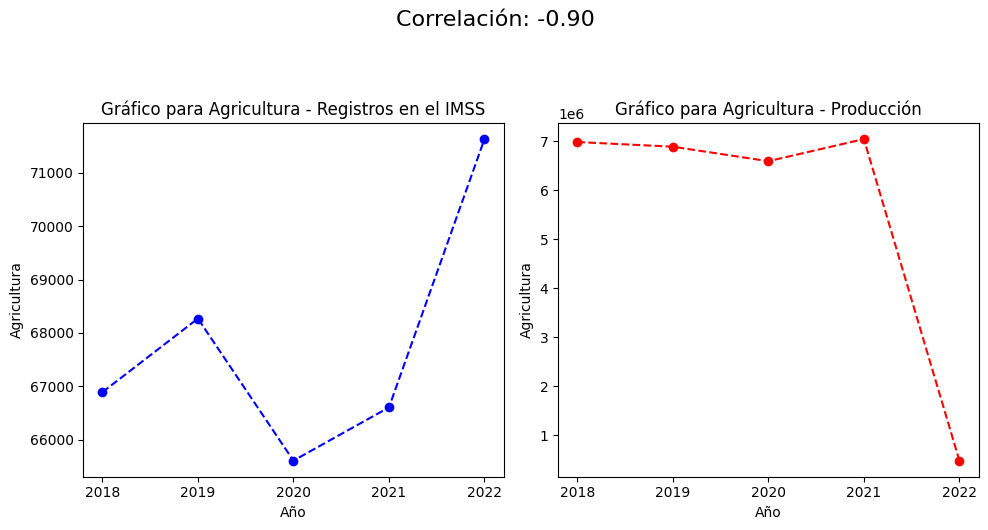

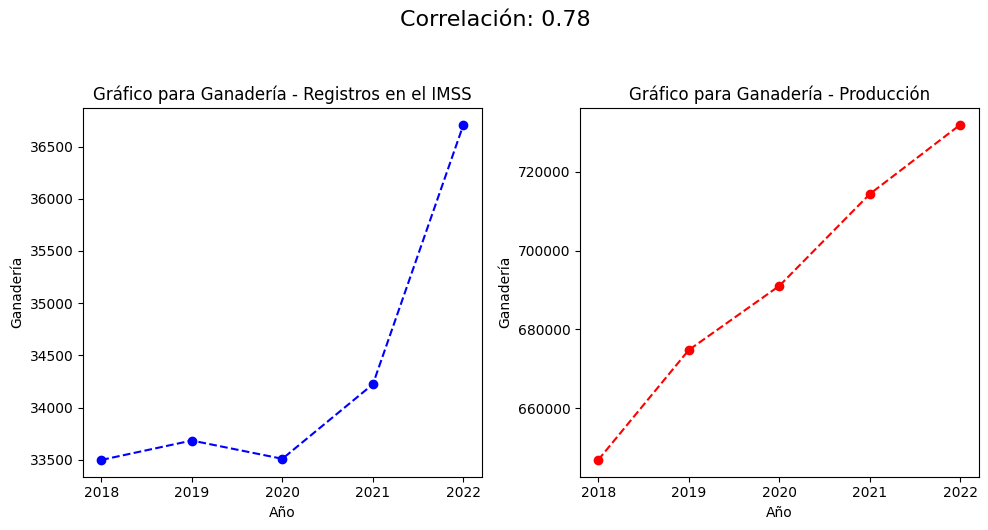

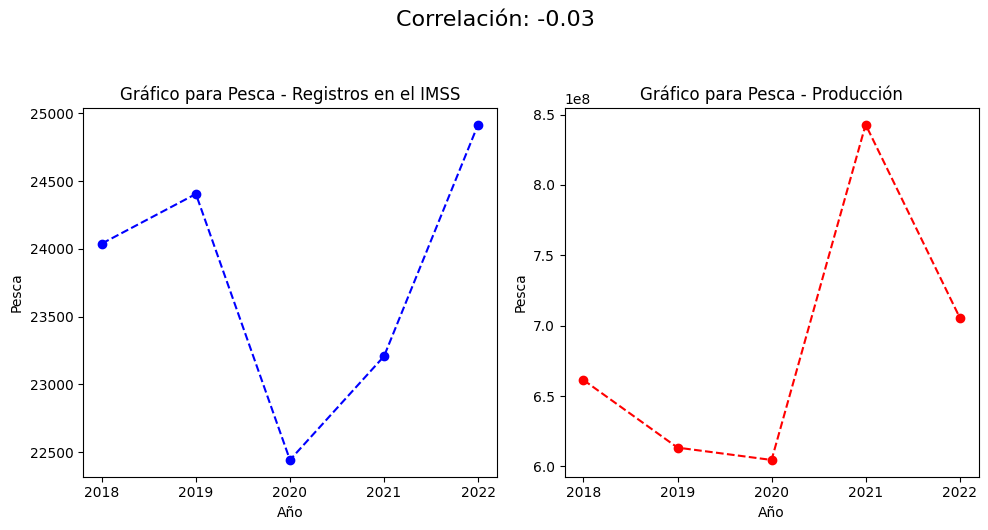

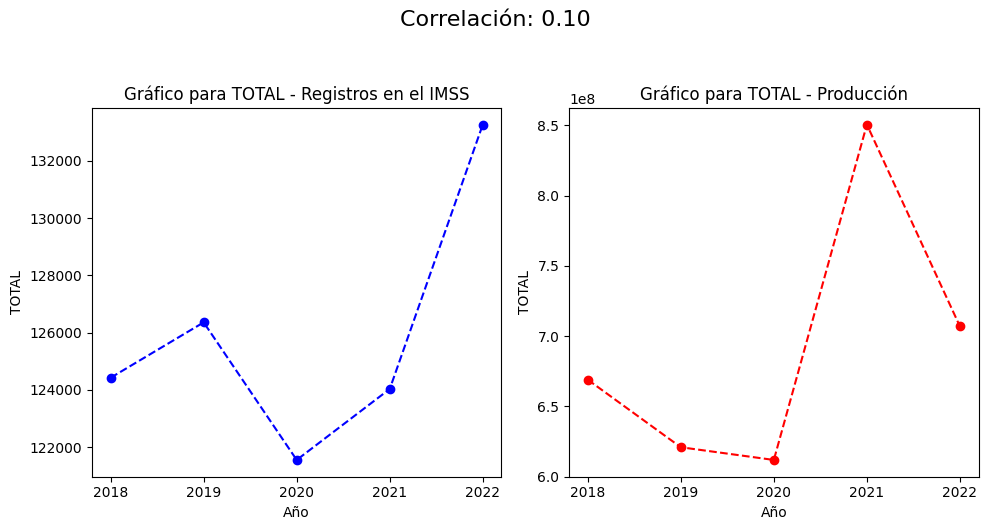

In [29]:
# Se realizan graficas por pares, para comparar el comportamiento de los registros y la produccion anual en cada sector
columns = produccion_total_anual.columns

for column in columns:
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(imss_registros_anual.index, imss_registros_anual[column], marker='o', linestyle='--', color='b')
    plt.title(f'Gráfico para {column} - Registros en el IMSS')
    plt.xlabel('Año')
    plt.xticks(imss_registros_anual.index)
    plt.ylabel(column)

    plt.subplot(1, 2, 2)
    plt.plot(produccion_total_anual.index, produccion_total_anual[column], marker='o', linestyle='--', color='r')
    plt.title(f'Gráfico para {column} - Producción')
    plt.xlabel('Año')
    plt.xticks(produccion_total_anual.index)
    plt.ylabel(column)

    correlation = np.corrcoef(imss_registros_anual[column], produccion_total_anual[column])[0, 1]
    plt.suptitle(f'Correlación: {correlation:.2f}', y=1.05, fontsize=16)
    

    plt.tight_layout()
    plt.show()

De momento el unico sector prometedor podría ser el sector ganadero.

Se puede cambiar el angulo buscando si la producción total anual por municipio tiene correlación con los registros del IMSS anuales. 

In [45]:
produccion_municipio_anual = df_agp[['ANO','CVE_MUN','PRODTON']].groupby(['ANO','CVE_MUN'])['PRODTON'].sum().sort_index(level=0)
produccion_municipio_anual = produccion_municipio_anual.unstack().drop(index = 2023)
produccion_municipio_anual

CVE_MUN,1,2,3,4,5,6,7,8,9,10,...,63,64,65,66,67,68,69,70,71,72
ANO,,,,,,,,,,,,,,,,,,,,,
2018,32311.464,26655.874,11737.817,112845.558,15627.562,38155.001,4028.366,4616.577,8514.690,5909.528,...,1814.132,30115.653,15223.398,112055.615,6639.408,11029.469,5653.865,30481.430,277580.712,313962.339
2019,26301.328,29809.465,17877.309,112609.607,16142.846,30667.124,2546.113,3489.919,9368.295,4308.661,...,2091.372,27616.629,8098.354,93514.276,6009.900,11032.117,6200.905,27744.760,307450.649,331081.075
2020,26639.615,31103.286,11492.257,116440.175,12741.736,32222.659,2823.436,3588.014,8386.459,4497.238,...,2021.892,26267.265,7615.685,86682.106,6262.870,7481.455,5929.390,31337.383,334025.808,321728.239
2021,15758.730,19662.420,17367.550,176123.530,14247.130,27270.540,2149.970,5197.410,9021.070,5546.720,...,2570.560,42782.430,6573.540,61056.880,6801.820,12411.430,9028.950,27037.580,320167.480,349030.450
2022,1165.246,1037.273,9952.412,170914.123,803.015,2780.818,2953.155,539.864,553.753,498.367,...,430.933,1525.295,1777.284,13252.851,766.346,2330.703,1260.493,128.923,4067.272,1690.632


In [31]:
claves_df = pd.read_csv('diccionarios\cvemun.csv', names=['cve_mun', 'municipio'])

df_imss['municipio'] = df_imss['municipio'].str.upper()
claves_df['municipio'] = claves_df['municipio'].str.upper()

df_imss_claves = pd.merge(df_imss, claves_df, on='municipio', how='left')

In [32]:
imss_municipio_anual = df_imss_claves[['ANO','cve_mun']].groupby(['ANO','cve_mun'])['cve_mun'].count()
imss_municipio_anual = imss_municipio_anual.unstack().fillna(0)
imss_municipio_anual

cve_mun,1,2,3,4,5,6,8,10,11,12,...,62,63,64,65,66,67,69,70,71,72
ANO,,,,,,,,,,,,,,,,,,,,,
2018,80.0,1357.0,304.0,1650.0,41.0,57.0,0.0,5.0,25.0,1010.0,...,36.0,5.0,49.0,10.0,530.0,24.0,11.0,552.0,1263.0,897.0
2019,24.0,1331.0,264.0,1594.0,88.0,58.0,0.0,12.0,36.0,898.0,...,36.0,9.0,151.0,10.0,656.0,32.0,12.0,610.0,1387.0,1137.0
2020,24.0,1228.0,258.0,1451.0,89.0,67.0,11.0,12.0,36.0,826.0,...,36.0,0.0,214.0,0.0,657.0,51.0,12.0,524.0,1488.0,1085.0
2021,32.0,1292.0,289.0,1500.0,51.0,61.0,12.0,12.0,35.0,840.0,...,46.0,0.0,223.0,0.0,679.0,51.0,12.0,581.0,1436.0,1121.0
2022,37.0,1359.0,303.0,1508.0,47.0,73.0,12.0,12.0,36.0,1062.0,...,34.0,0.0,204.0,36.0,637.0,37.0,3.0,722.0,1491.0,1398.0


In [50]:
mun_corr = []

for cve in claves_df['cve_mun']:
    try:
        correlation = np.corrcoef(imss_municipio_anual[cve], produccion_municipio_anual[cve])[0, 1]
        mun_corr.append({
            'cve_mun': cve,
            'correlation': correlation
        })
    except KeyError:
        pass

mun_corr = pd.DataFrame(mun_corr)

mun_corr_top = mun_corr.loc[mun_corr['correlation'] > 0.75]
mun_corr_top=pd.merge(mun_corr_top, claves_df, on = 'cve_mun')[['municipio', 'cve_mun', 'correlation']]
mun_corr_top

,municipio,cve_mun,correlation
0,CARBÓ,20,0.803296
1,PITIQUITO,47,0.876945
2,SANTA CRUZ,59,0.770706
3,YÉCORA,69,0.892113


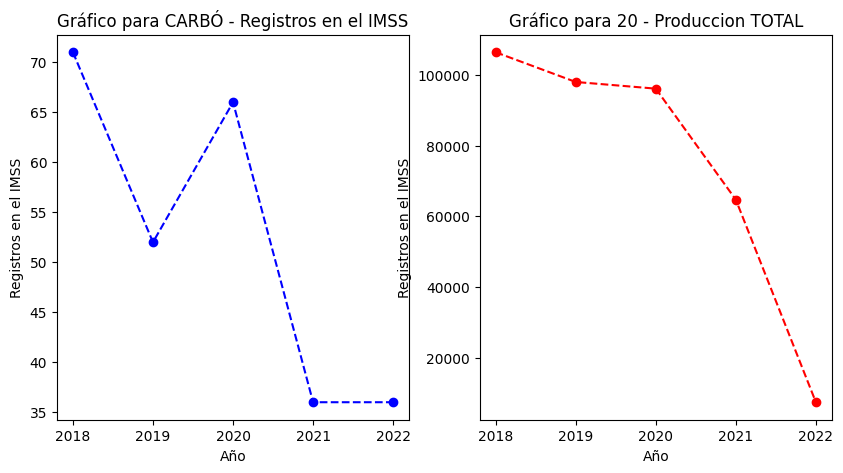

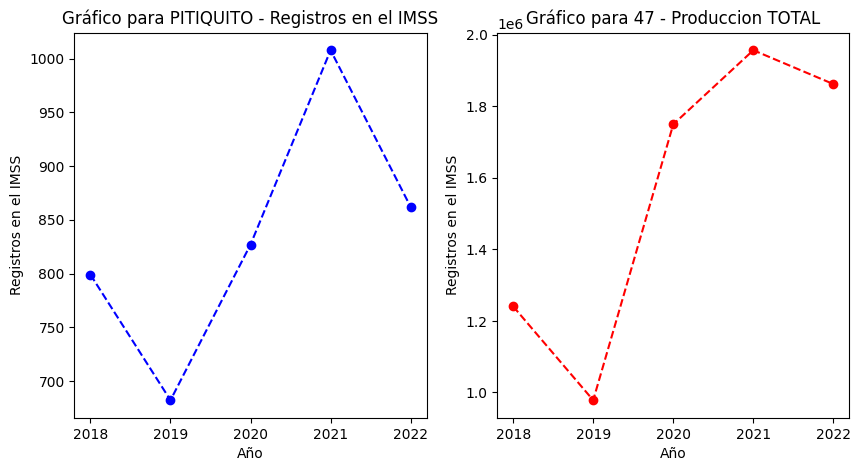

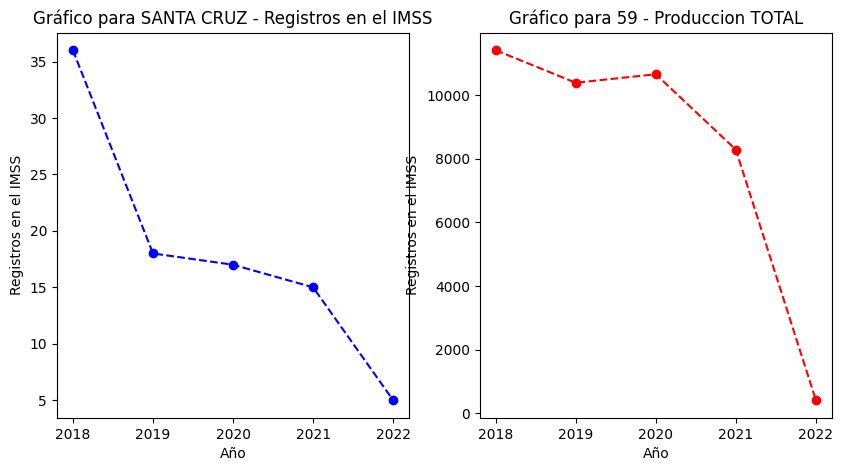

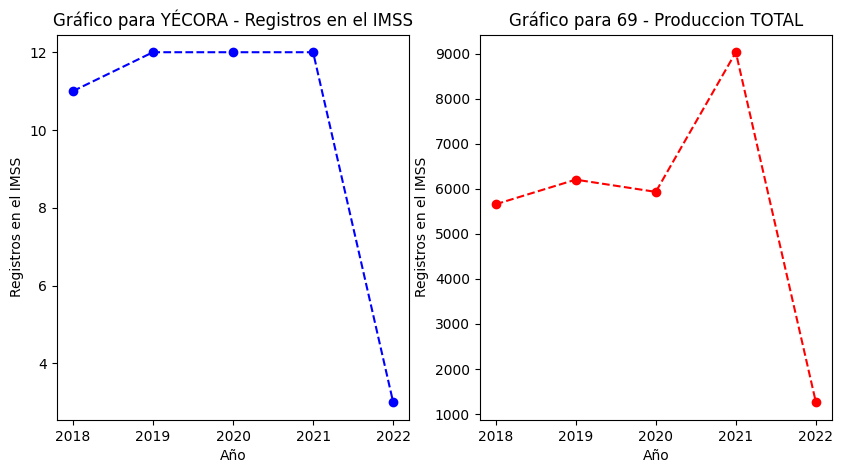

In [52]:
#Registros anuales por sector por municipio
df_imss_top_corr = df_imss[df_imss['municipio'].isin(mun_corr_top['municipio'])]
imss_registros_anual_top_corr = df_imss_top_corr[['ANO', 'SECTOR', 'municipio']].groupby(['ANO','SECTOR', 'municipio'])['SECTOR'].count()
imss_registros_anual_top_corr = imss_registros_anual_top_corr.unstack('SECTOR')
imss_registros_anual_top_corr['TOTAL'] = imss_registros_anual_top_corr[['Agricultura', 'Ganadería', 'Pesca']].sum(axis=1)
imss_registros_anual_top_corr

#Produccion anual por sector por municipio
df_agp_top_corr = df_agp[df_agp['CVE_MUN'].isin(mun_corr_top['cve_mun'])]
prod_mun_top_corr = df_agp_top_corr[['ANO','SECTOR','PRODTON','CVE_MUN']].groupby(['ANO','SECTOR','CVE_MUN'])['PRODTON'].sum()
prod_mun_top_corr = prod_mun_top_corr.unstack('SECTOR')
prod_mun_top_corr['TOTAL'] = prod_mun_top_corr[['Agricultura', 'Ganadería', 'Pesca']].sum(axis=1)
prod_mun_top_corr

# Graficar el total de cada municipio a lo largo de los años
municipios = imss_registros_anual_top_corr.index.get_level_values('municipio').unique()
claves = prod_mun_top_corr.index.get_level_values('CVE_MUN').unique()
years = imss_registros_anual_top_corr.index.get_level_values('ANO').unique()

for municipio in zip(municipios, claves):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    registros_municipio = imss_registros_anual_top_corr.loc[imss_registros_anual_top_corr.index.get_level_values('municipio') == municipio[0]]
    plt.plot(years, registros_municipio['TOTAL'],marker='o', linestyle='--', color='b')
    plt.title(f'Gráfico para {municipio[0]} - Registros en el IMSS')
    plt.xlabel('Año')
    plt.xticks(imss_registros_anual.index)
    plt.ylabel('Registros en el IMSS')

    plt.subplot(1, 2, 2)
    produccion_municipio = prod_mun_top_corr.loc[prod_mun_top_corr.index.get_level_values('CVE_MUN') == municipio[1]]
    plt.plot(years, produccion_municipio['TOTAL'],marker='o', linestyle='--', color='r')
    plt.title(f'Gráfico para {municipio[1]} - Produccion TOTAL')
    plt.xlabel('Año')
    plt.xticks(imss_registros_anual.index)
    plt.ylabel('Registros en el IMSS')

    plt.show()


Se puede ver que para estos municipios el nivel de producción total coincide mucho en comportamiento a la grafica de registros ante el IMSS. La linea a seguir a partir de este resultado sería considerar si este resultado es significativo conocienco el contexto de estos municipios y que particularides pueden producir este comportamiento.